In [23]:
import os
from pathlib import Path
import pandas as pd
import torch
from torch.utils.data import random_split
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F

# === 1. CONFIGURATION ===
DATA_ROOT = Path("data")
XYZ_DIR = DATA_ROOT / "atoms" / "train"
ENERGY_CSV = DATA_ROOT / "energies" / "train.csv"

# === 2. UTILS ===
ATOM_TYPES = ['H', 'C', 'N', 'O', 'F', 'S', 'Cl']  # adapt as needed

def atom_to_int(symbol):
    return ATOM_TYPES.index(symbol)

def z_to_one_hot(z, num_classes=7):
    return F.one_hot(z, num_classes=num_classes).float()

def build_edge_index(pos, cutoff=1.5):
    dist = torch.cdist(pos, pos)
    mask = (dist < cutoff) & (dist > 0)
    row, col = torch.where(mask)
    edge_index = torch.stack([row, col], dim=0)
    return edge_index


In [24]:
# === 3. DATASET ===
class QM7XDataset(Dataset):
    def __init__(self, xyz_dir, energy_csv, cutoff=1.5):
        super().__init__()
        self.xyz_dir = xyz_dir
        self.cutoff = cutoff
        self.energy_df = pd.read_csv(energy_csv, index_col='id')

    def __len__(self):
        return len(self.energy_df)

    def _load_xyz(self, file_path):
        with open(file_path, 'r') as f:
            lines = f.readlines()[2:]
        atoms = []
        positions = []
        for line in lines:
            parts = line.split()
            atoms.append(atom_to_int(parts[0]))
            positions.append([float(x) for x in parts[1:4]])
        z = torch.tensor(atoms, dtype=torch.long)
        pos = torch.tensor(positions, dtype=torch.float)
        return z, pos

    def __getitem__(self, idx):
        mol_id = idx + 1
        file_path = self.xyz_dir / f"id_{mol_id}.xyz"
        z, pos = self._load_xyz(file_path)
        x = z_to_one_hot(z)
        edge_index = build_edge_index(pos, self.cutoff)
        energy = torch.tensor([self.energy_df.loc[mol_id, 'energy']], dtype=torch.float)
        data = Data(x=x, edge_index=edge_index, pos=pos, y=energy)
        return data


In [3]:
# === 4. MODEL ===
class GCNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin = torch.nn.Linear(hidden_dim, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x).view(-1)
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Sequential
from torch_geometric.nn import GINConv, global_mean_pool

class PretrainedGIN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()

        nn1 = Sequential(Linear(input_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
        self.conv1 = GINConv(nn1)

        nn2 = Sequential(Linear(hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
        self.conv2 = GINConv(nn2)

        self.lin = Linear(hidden_dim, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x).view(-1)



In [4]:
# === 5. ENTRAINEMENT ===
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        pred = model(data)
        loss = F.mse_loss(pred, data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def test(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data)
            loss = F.mse_loss(pred, data.y.view(-1))
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)


In [ ]:
# === 6. MAIN ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = QM7XDataset(XYZ_DIR, ENERGY_CSV)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)

sample_data = next(iter(train_loader))
input_dim = sample_data.num_node_features

model = PretrainedGIN(input_dim=input_dim, hidden_dim=64).to(device)
#model = GCNModel(input_dim=input_dim, hidden_dim=64).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, 101):
    loss = train(model, train_loader, optimizer)
    val_loss = test(model, val_loader)
    print(f"Epoch {epoch:02d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}")

/home/n7student/miniforge3/envs/dl/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 01, Train Loss: 1760.8696, Val Loss: 166.8912
Epoch 02, Train Loss: 105.1591, Val Loss: 60.8368
Epoch 03, Train Loss: 63.4807, Val Loss: 57.1740
Epoch 04, Train Loss: 60.9322, Val Loss: 54.1115
Epoch 05, Train Loss: 58.1033, Val Loss: 51.2842
Epoch 06, Train Loss: 55.0760, Val Loss: 48.9299
Epoch 07, Train Loss: 53.1732, Val Loss: 48.1403
Epoch 08, Train Loss: 50.3651, Val Loss: 45.7956
Epoch 09, Train Loss: 49.5373, Val Loss: 42.5520
Epoch 10, Train Loss: 48.4131, Val Loss: 43.5039
Epoch 11, Train Loss: 45.7939, Val Loss: 42.3068
Epoch 12, Train Loss: 45.1756, Val Loss: 41.5665
Epoch 13, Train Loss: 44.4634, Val Loss: 40.0171
Epoch 14, Train Loss: 46.6342, Val Loss: 39.2734
Epoch 15, Train Loss: 43.2274, Val Loss: 38.6772
Epoch 16, Train Loss: 43.3369, Val Loss: 43.2774
Epoch 17, Train Loss: 41.3282, Val Loss: 39.1722
Epoch 18, Train Loss: 42.2200, Val Loss: 37.9949
Epoch 19, Train Loss: 40.5938, Val Loss: 39.9441
Epoch 20, Train Loss: 41.4758, Val Loss: 38.4921
Epoch 21, Train 

In [10]:
import matplotlib.pyplot as plt

def evaluate_and_plot(model, loader, title="Train set"):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data)
            y_true.append(data.y.view(-1).cpu())
            y_pred.append(pred.view(-1).cpu())

    # Concaténer tous les batches
    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    # === Affichage graphique ===
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k', s=40)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Vraie valeur")
    plt.ylabel("Prédiction")
    plt.title(f"Prédiction vs vérité ({title})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Calcul du RMSE
    rmse = torch.sqrt(F.mse_loss(torch.tensor(y_pred), torch.tensor(y_true))).item()
    print(f"RMSE sur {title} : {rmse:.4f}")


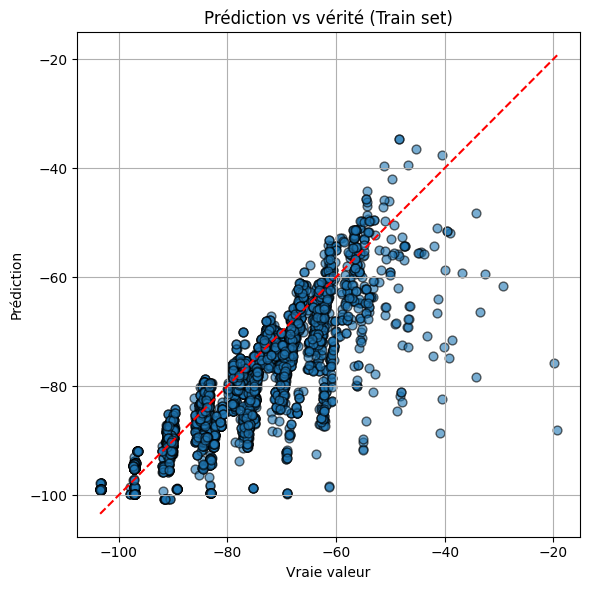

RMSE sur Train set : 6.5997


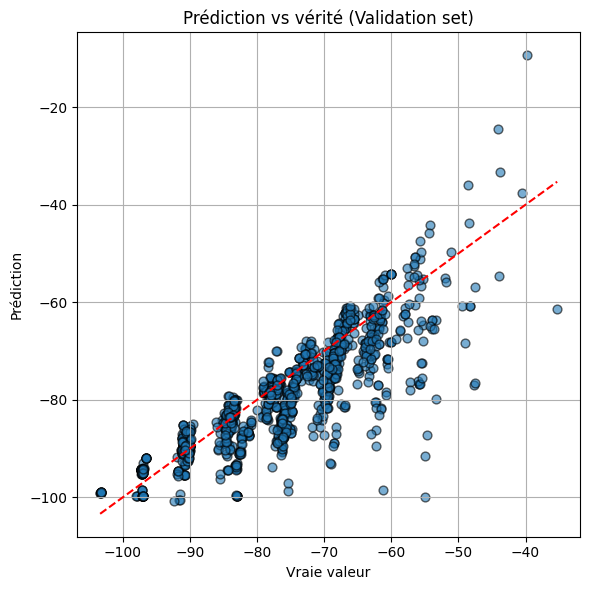

RMSE sur Validation set : 6.6788


In [11]:
evaluate_and_plot(model, train_loader, title="Train set")
evaluate_and_plot(model, val_loader, title="Validation set")


## AE

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, BatchNorm

class GCNAutoEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=128, latent_dim=64, dropout=0.3):
        super().__init__()
        # encodeur
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = BatchNorm(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = BatchNorm(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, latent_dim)
        self.bn3 = BatchNorm(latent_dim)

        self.dropout = dropout

        # décodeur (MLP symétrique)
        self.lin1 = torch.nn.Linear(latent_dim, hidden_dim)
        self.bn4 = torch.nn.BatchNorm1d(hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, input_dim)

    def encode(self, x, edge_index):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.bn3(self.conv3(x, edge_index)))
        return x

    def decode(self, z):
        z = F.relu(self.bn4(self.lin1(z)))
        z = F.dropout(z, p=self.dropout, training=self.training)
        z = self.lin2(z)
        return z

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        z = self.encode(x, edge_index)
        x_recon = self.decode(z)
        # skip connection : on ajoute l'entrée pour aider la reconstruction
        x_recon = x_recon + x
        return x_recon


In [5]:
import torch
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Chargement du dataset QM7XDataset (à adapter si nécessaire)
dataset = QM7XDataset(XYZ_DIR, ENERGY_CSV)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)

sample_data = next(iter(train_loader))
input_dim = sample_data.num_node_features

# Instanciation du modèle autoencoder
model = GCNAutoEncoder(input_dim=input_dim, hidden_dim=64, latent_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        x_recon = model(data)
        loss = torch.nn.functional.mse_loss(x_recon, data.x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def validate_epoch(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            x_recon = model(data)
            loss = torch.nn.functional.mse_loss(x_recon, data.x)
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

# Boucle d'entraînement avec validation
for epoch in range(1, 11):
    train_loss = train_epoch(model, train_loader, optimizer)
    val_loss = validate_epoch(model, val_loader)
    print(f"Epoch {epoch:02d}, Train Loss: {train_loss}, Val Loss: {val_loss}")


/home/n7student/miniforge3/envs/dl/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 01, Train Loss: 0.03627985099977807, Val Loss: 0.00031776837047847544
Epoch 02, Train Loss: 0.0031606167231930903, Val Loss: 7.734528120583837e-05
Epoch 03, Train Loss: 0.0009427882497953548, Val Loss: 2.8161899221489466e-05
Epoch 04, Train Loss: 0.00040484509745800703, Val Loss: 1.5583456403237712e-05
Epoch 05, Train Loss: 0.00020116367614499473, Val Loss: 8.165345501520367e-06
Epoch 06, Train Loss: 0.00010729646256772239, Val Loss: 4.5114088079585745e-06
Epoch 07, Train Loss: 6.0960964833853314e-05, Val Loss: 2.405980185109971e-06
Epoch 08, Train Loss: 3.495469687006447e-05, Val Loss: 1.3659624209291028e-06
Epoch 09, Train Loss: 2.091988004361684e-05, Val Loss: 8.896665634692343e-07
Epoch 10, Train Loss: 1.2603798237466182e-05, Val Loss: 5.499684719023834e-07


In [6]:
# Importer torch_geometric
import torch_geometric
def extract_embeddings(model, loader, device):
    model.eval()
    embeddings = []
    energies = []  # target variable
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            z = model.encode(data.x, data.edge_index)  # [num_nodes, latent_dim]

            # Moyenne globale par graphe (molecule) car dataset batché
            batch = data.batch
            z_pool = torch_geometric.nn.global_mean_pool(z, batch)  # [batch_size, latent_dim]

            embeddings.append(z_pool.cpu())
            energies.append(data.y.cpu())  # attention : il faut que ton dataset ait y = énergie
    embeddings = torch.cat(embeddings, dim=0)
    energies = torch.cat(energies, dim=0)
    return embeddings.numpy(), energies.numpy()


In [7]:
train_embeddings, train_energies = extract_embeddings(model, train_loader, device)
val_embeddings, val_energies = extract_embeddings(model, val_loader, device)


In [9]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

xgb_regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    random_state=42
)

xgb_regressor.fit(train_embeddings, train_energies)

# Resultat sur le train
train_preds = xgb_regressor.predict(train_embeddings)
mse = mean_squared_error(train_energies, train_preds)
print(f"Tranning RMSE XGBoost: {mse**0.5:.6f}")

# Resultat sur le test
val_preds = xgb_regressor.predict(val_embeddings)
mse = mean_squared_error(val_energies, val_preds)
print(f"Validation RMSE XGBoost: {mse**0.5:.6f}")


Tranning RMSE XGBoost: 0.559447
Validation RMSE XGBoost: 2.725268


In [10]:
class QM7XDataset_AE(Dataset):
    def __init__(self, xyz_dir, energy_csv=None, cutoff=1.5):
        super().__init__()
        self.xyz_dir = xyz_dir
        self.cutoff = cutoff
        self.has_energy = energy_csv is not None
        if self.has_energy:
            self.energy_df = pd.read_csv(energy_csv, index_col='id')
            self.file_map = [(i, self.xyz_dir / f"id_{i}.xyz") for i in self.energy_df.index]
        else:
            self.file_map = [
                (int(p.stem.split("_")[1]), p)
                for p in sorted(self.xyz_dir.glob("id_*.xyz"))
            ]

    def __len__(self):
        return len(self.file_map)

    def _load_xyz(self, file_path):
        with open(file_path, 'r') as f:
            lines = f.readlines()[2:]
        atoms = []
        positions = []
        for line in lines:
            parts = line.split()
            atoms.append(atom_to_int(parts[0]))
            positions.append([float(x) for x in parts[1:4]])
        z = torch.tensor(atoms, dtype=torch.long)
        pos = torch.tensor(positions, dtype=torch.float)
        return z, pos

    def __getitem__(self, idx):
        mol_id, file_path = self.file_map[idx]
        z, pos = self._load_xyz(file_path)
        x = z_to_one_hot(z)
        edge_index = build_edge_index(pos, self.cutoff)

        data = Data(x=x, edge_index=edge_index, pos=pos)

        if self.has_energy and mol_id in self.energy_df.index:
            energy = torch.tensor([self.energy_df.loc[mol_id, 'energy']], dtype=torch.float)
        else:
            energy = torch.tensor([float('nan')], dtype=torch.float)

        data.y = energy
        return data



In [53]:
from torch.utils.data import ConcatDataset, random_split
from torch_geometric.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset avec énergies (train)
dataset_train = QM7XDataset_AE(DATA_ROOT / "atoms" / "train", ENERGY_CSV)

# Dataset sans énergies (test)
dataset_test = QM7XDataset_AE(DATA_ROOT / "atoms" / "test", energy_csv=None)

# Fusion des deux datasets
full_dataset = ConcatDataset([dataset_train, dataset_test])

# Split 90% pour train, 10% pour validation
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)

# Dimension d'entrée (depuis un batch)
sample_data = next(iter(train_loader))
input_dim = sample_data.num_node_features

# Autoencoder
model = GCNAutoEncoder(input_dim=input_dim, hidden_dim=64, latent_dim=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        x_recon = model(data)
        loss = torch.nn.functional.mse_loss(x_recon, data.x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def validate_epoch(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            x_recon = model(data)
            loss = torch.nn.functional.mse_loss(x_recon, data.x)
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

# Boucle d'entraînement
for epoch in range(1, 101):
    train_loss = train_epoch(model, train_loader, optimizer)
    val_loss = validate_epoch(model, val_loader)
    print(f"Epoch {epoch:02d}, Train Loss: {train_loss}, Val Loss: {val_loss}")


/home/n7student/miniforge3/envs/dl/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 01, Train Loss: 0.02647869945890671, Val Loss: 7.368935501254932e-05
Epoch 02, Train Loss: 0.0011436425362738004, Val Loss: 1.2912051680509692e-05
Epoch 03, Train Loss: 0.0003253429773026092, Val Loss: 4.079815399449022e-06
Epoch 04, Train Loss: 0.00013862571938909638, Val Loss: 1.7110293382871727e-06
Epoch 05, Train Loss: 7.190997360979785e-05, Val Loss: 8.778661416179656e-07
Epoch 06, Train Loss: 4.106401609232557e-05, Val Loss: 6.564289980276742e-07
Epoch 07, Train Loss: 2.465237829241186e-05, Val Loss: 4.391781393440273e-07
Epoch 08, Train Loss: 1.5405810843803293e-05, Val Loss: 4.0901215014661293e-07
Epoch 09, Train Loss: 1.0260651928417763e-05, Val Loss: 4.58185195053304e-07
Epoch 10, Train Loss: 6.705731261358598e-06, Val Loss: 2.836024334467686e-07
Epoch 11, Train Loss: 4.462458727515838e-06, Val Loss: 2.9266207049164505e-07
Epoch 12, Train Loss: 3.170063951142023e-06, Val Loss: 3.1265764539622394e-07
Epoch 13, Train Loss: 2.2416306182366154e-06, Val Loss: 2.3360318407169

In [54]:
# Importer torch_geometric
import torch_geometric
def extract_embeddings(model, loader, device):
    model.eval()
    embeddings = []
    energies = []  # target variable
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            z = model.encode(data.x, data.edge_index)  # [num_nodes, latent_dim]

            # Moyenne globale par graphe (molecule) car dataset batché
            batch = data.batch
            z_pool = torch_geometric.nn.global_mean_pool(z, batch)  # [batch_size, latent_dim]

            embeddings.append(z_pool.cpu())
            energies.append(data.y.cpu())  # attention : il faut que ton dataset ait y = énergie
    embeddings = torch.cat(embeddings, dim=0)
    energies = torch.cat(energies, dim=0)
    return embeddings.numpy(), energies.numpy()


In [55]:
DATA_ROOT = Path("data")
XYZ_DIR = DATA_ROOT / "atoms" / "train"
ENERGY_CSV = DATA_ROOT / "energies" / "train.csv"

In [56]:
train_embeddings, train_energies = extract_embeddings(model, train_loader, device)
val_embeddings, val_energies = extract_embeddings(model, val_loader, device)


In [57]:
from pathlib import Path
from torch_geometric.loader import DataLoader

xyz_dir = Path("data/atomes/train")  # ← change ça
csv_path = "data/energies/train.csv"

dataset = QM7XDataset(xyz_dir, csv_path)
loader = DataLoader(dataset, batch_size=64, shuffle=False)


In [58]:
def extract_embeddings(model, loader, device):
    model.eval()
    embeddings, energies = [], []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            emb = model.encoder(batch.x, batch.edge_index, batch.pos, batch.batch)
            embeddings.append(emb.cpu())
            energies.append(batch.y.cpu())

    embeddings = torch.cat(embeddings, dim=0).numpy()
    energies = torch.cat(energies, dim=0).squeeze().numpy()
    return embeddings, energies


In [59]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LinearRegression

# Supposons que tu as déjà : train_embeddings, train_energies
# embeddings.shape = (N, latent_dim), energies.shape = (N, 1) ou (N,)
if train_energies.ndim > 1:
    train_energies = train_energies.ravel()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmses = []
for fold, (train_idx, val_idx) in enumerate(kf.split(train_embeddings)):
    X_train, X_val = train_embeddings[train_idx], train_embeddings[val_idx]
    y_train, y_val = train_energies[train_idx], train_energies[val_idx]


    xgb_regressor = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        random_state=42
    )

    # Pour NumPy array
    mask = ~np.isnan(y_train)
    X_train = X_train[mask]
    y_train = y_train[mask]

    xgb_regressor.fit(X_train, y_train)


    
    val_preds = xgb_regressor.predict(X_val)
    mask = ~np.isnan(y_val)
    y_val = y_val[mask]
    val_preds = val_preds[mask]
    rmse = mean_squared_error(y_val, val_preds)**0.5
    print(f"Fold {fold+1} RMSE: {rmse:.6f}")
    rmses.append(rmse)

print(f"\nCross-validated RMSE: {np.mean(rmses):.6f} ± {np.std(rmses):.6f}")


Fold 1 RMSE: 3.918067
Fold 2 RMSE: 3.429340
Fold 3 RMSE: 3.809983
Fold 4 RMSE: 3.364839
Fold 5 RMSE: 3.025253

Cross-validated RMSE: 3.509496 ± 0.322200
